# Latente Semantic Analysis (LSA)

Latent semantic analysis (LSA) is a technique in natural language processing, in particular distributional semantics, of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms. LSA assumes that words that are close in meaning will occur in similar pieces of text (the distributional hypothesis). A matrix containing word counts per paragraph (rows represent unique words and columns represent each paragraph) is constructed from a large piece of text and a mathematical technique called singular value decomposition (SVD) is used to reduce the number of rows while preserving the similarity structure among columns. Words are then compared by taking the cosine of the angle between the two vectors (or the dot product between the normalizations of the two vectors) formed by any two rows. Values close to 1 represent very similar words while values close to 0 represent very dissimilar words.

## Step 0: Compute TF-ID 

cf TF-IDF notebook for more informations

In [2]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import itertools
import numpy as np 
import math


# Get some data
documents = []

documents.append("""Python is a 2000 made-for-TV horror movie directed by Richard Clabaugh. 
The film features several cult favorite actors, including William
Zabka of The Karate Kid fame, Wil Wheaton, Casper Van Dien, Jenny McCarthy,
Keith Coogan, Robert Englund (best known for his role as Freddy Krueger in the
A Nightmare on Elm Street series of films), Dana Barron, David Bowe, and Sean
Whalen. The film concerns a genetically engineered snake, a python, that
escapes and unleashes itself on a small town. It includes the classic final
girl scenario evident in films like Friday the 13th. It was filmed in Los Angeles,
 California and Malibu, California. Python was followed by two sequels: Python
 II (2002) and Boa vs. Python (2004), both also made-for-TV films.""")

documents.append("""Python, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous pythons[2] found in Africa and Asia. Currently, 7 species are
recognised.[2] A member of this genus, P. reticulatus, is among the longest
snakes known.""")

documents.append("""The Colt Python is a .357 Magnum caliber revolver formerly
manufactured by Colt's Manufacturing Company of Hartford, Connecticut.
It is sometimes referred to as a "Combat Magnum".[1] It was first introduced
in 1955, the same year as Smith &amp; Wesson's M29 .44 Magnum. The now discontinued
Colt Python targeted the premium revolver market segment. Some firearm
collectors and writers such as Jeff Cooper, Ian V. Hogg, Chuck Hawks, Leroy
Thompson, Renee Smeets and Martin Dougherty have described the Python as the
finest production revolver ever made.""")


lemmatizer = WordNetLemmatizer()
stopwords = [l.rstrip() for l in open('stopwords.txt').read()]

def tokenize(document):
    # Put everything to lowercase
    document = document.lower()
    
    # Split document into words (=tokens) 
    tokens = word_tokenize(document)
    
    # Remove all words that are too small
    tokens = [t for t in tokens if len(t) > 2]
    
    # Remove all stopwords
    tokens = [t for t in tokens if t not in stopwords]
    
    # Turn tokens into their base form
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # Removes all digits
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] 
    
    return tokens


# Tokenize all documents
all_tokens = [tokenize(d) for d in documents]

# Get all tokens in a single array and removes duplicates 
vocabulary = list(set(itertools.chain.from_iterable(all_tokens)))

# Dict that maps word: index
word_index_map = {w: i for i, w in enumerate(vocabulary)}

# Compute TF
D = len(all_tokens)
W = len(vocabulary)
tf = np.zeros((D, W))

for i in range(D):
    total_words = len(all_tokens[i])
    for t in all_tokens[i]:
        tf[i,word_index_map[t]] += 1/total_words
        
# Compute IDF 
idf = np.zeros(W)
for token in vocabulary:
    for tokens in all_tokens:
        if token in tokens:
            idf[word_index_map[token]] += 1

idf = [math.log(D/i) for i in idf]



#--- Compute TF-IDF
tf_idf = tf * idf

#--- Transpose for SVD 
tf_idf = tf_idf.T

## Step 1: Singular Value Decomposition

<p>The SVD of an $m \times n$ matrix $A$ with real values is a factorization of $A$ as $U \Sigma V^T$, where $U$ is an $m \times m$ orthogonal matrix, $V$ is an $n \times n$ orthogonal matrix, and $\Sigma$ is a diagonal matrix with nonnegative real entries on the diagonal. </p>

Properties: 
- $V$ diaganolize $A^TA$  
- $U$ diagonalize $AA^T$

<p>Check out https://jeremykun.com/2016/04/18/singular-value-decomposition-part-1-perspectives-on-linear-algebra/ for more intuition and informations about SVD.</p>

### Step 1.1: SVD example n°1 (need fix!)
Let's have a small example on the consequences of applying SVD. Here, we would like to see what are the results of compressing rows of an image with different numbers of components:

Original image: (620, 475)
<class 'numpy.ndarray'>


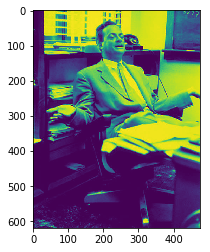

In [3]:
from scipy.ndimage import imread
from matplotlib.pyplot import imshow

image = imread('feynman.png')
print('Original image:', image.shape)
print(type(image))

%matplotlib inline
imshow(image)

Computing the SVD has become simple thanks to numpy:

In [4]:
U, s, V = np.linalg.svd(image)

print('U is shape', U.shape)
print('V is shape', V.shape)
print('s is shape', s.shape)



U is shape (620, 620)
V is shape (475, 475)
s is shape (475,)


Now we take the first n components and see what the dimension reduction does to the image:

len image : 620
len vt: 475


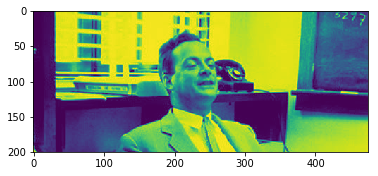

In [6]:
from scipy.linalg import svd, diagsvd


n_components = [10, 25, 50]


u,sigma,vt = svd(image)

u = u[:200]

#Reconstruct MATRIX'
reconstructedMatrix= np.dot(np.dot(u, diagsvd(sigma,len(image), len(vt))), vt)

print('len image :', len(image))
print('len vt:', len(vt))

#best_components = s[:n]
#reconstructed = np.dot(np.dot(U,s),V)
imshow(reconstructedMatrix)

if np.array_equal(image, reconstructedMatrix):
    print('Exactly the same image')


### Step 1.2: Apply 